##**Pre-setting** :

###Import and Define function:

In [1]:
import datetime as dt
import pandas_datareader.data as dr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
#import keras_tuner as kt
#from pandas_datareader.yahoo.daily import YahooDailyReader
from sklearn.preprocessing import MinMaxScaler

#import measure
import math
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
def RMSE(y_true,y_false):
  return math.sqrt(MSE(y_true,y_false))
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#import Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble  import AdaBoostRegressor
from sklearn.ensemble  import VotingRegressor
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf

In [2]:
def get_next_weekday(today):
  next_day = today + dt.timedelta(days=1)
  while (next_day.dayofweek > 4):
    next_day = next_day + dt.timedelta(days=1)
  return next_day

def add_next_pred_entry(df_current, pred_value):
  df_temp = pd.DataFrame(pred_value,index=[get_next_weekday(df_current.tail(1).index[0])]  , columns=[target])
  df_current = df_current.append(df_temp)

  #calculate Indicator
  df_current[target+'_lg'] = np.log(1+df_current[target].pct_change())
  df_current['MA'+'_'+'20'] = ma(df_current[target],20)
  df_current['MA'+'_'+'50'] = ma(df_current[target],50)
  df_current['MA'+'_'+'100'] = ma(df_current[target],100)
  df_current['MA'+'_'+'200'] = ma(df_current[target],200)
  df_current['RSI'] = rsi(df_current[target], 14,True  )
  macd_current = macd(df_current[target],26,12,9)
  df_current['MACD'] = macd_current['MACD']
  df_current['signal'] = macd_current['signal']
  df_current['hist'] = macd_current['hist']

  return df_current

In [3]:
def moving_average (list_price,n):
  ma_list = [None]*len(list_price)
  for i in range(len(list_price)):
    if i < n - 1 :
      ma_list[i] = 0
    elif i == n-1 :
      ma_list[i] = sum(list_price[i-n+1:i+1])/n
    else :
      ma_list[i] = ma_list[i-1] + list_price[i]/n - list_price[i-n]/n
  return ma_list

  
def ma(df,periods=50, ema = False):
  if ema == True:
	    # Use exponential moving average
      ma_list = df.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
  else:
      # Use simple moving average
      ma_list = df.rolling(window = periods).mean()
  return ma_list;


def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    db_macd = pd.DataFrame(exp1 - exp2)
    signal = pd.DataFrame(db_macd.ewm(span = smooth, adjust = False).mean())
    hist = pd.DataFrame(db_macd - signal)
    df = pd.DataFrame(db_macd).rename(columns = {target:'MACD'})
    #df[('MACD','macd')]=db_macd
    df['signal']=signal
    df['hist']=hist
    return df




In [4]:
def plot(X,Ytest=None,Ypred=None,Y3=None,Xtrain=None,Ytrain=None,Title=None,Xlabel=None,Ylabel=None):
  plt.style.use('seaborn')
  plt.figure(figsize=(32,16))
  
  if type(Ytest) is not type(None):
    plt.plot(X,Ytest, '-b', markersize=20, label = 'Actual')

  if type(Ypred) is not type(None):
    plt.plot(X,Ypred, '-r', markersize=15, label = 'Predict')

  if type(Y3) is not type(None):
    plt.plot(X,Y3, '-g', markersize=15, label = 'Y3')

  if type(Ytrain) is not type(None) and type(Xtrain) is not type(None):
    plt.plot(Xtrain,Ytrain, '-b', markersize=15)

    
  plt.title(Title,fontsize=18)
  plt.xlabel(Xlabel,fontsize=16)
  plt.ylabel(Ylabel,fontsize=16)
  plt.legend(loc="upper left",fontsize= 'large')
  

def result(y_true,y_pred, name=''):
  rmse_pred = RMSE(y_true,y_pred)
  mae_pred = MAE(y_true,y_pred)
  mape_pred = MAPE(y_true,y_pred)
  print(name,'RMSE:', rmse_pred)
  print(name,'MAE: ', mae_pred)
  print(name,'MAPE:', mape_pred)


###Link and Important variable

In [5]:

!python --version
print(tf.__version__)


Python 3.7.12
2.6.0


In [6]:
#symbol of stock to predict.
#The first symbol will be the prediction target
stock = 'TSLA'
#stock = ['TSLA']

#value need to predict
order = ['Open', 'High', 'Low', 'Close']

#moving average to add
ma_list =[20,50,100,200]

#terget to predict price
target = 'Close'

#total day for prediction
days = 30

> Read Stock: [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/)\
> Pandas: [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)\
> Sklearn: [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)\
> Tensorflow: [Tensorflow](https://www.tensorflow.org/tutorials/keras/regression)

###Note:

##**Preprocessing**

In [7]:
rawdf = dr.DataReader(stock,'stooq', start='01-01-2008', end=dt.datetime.today() )
rawdf

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-14,815.490,820.250,813.3501,818.320,12247170.0
2021-10-13,810.470,815.410,805.7800,811.080,14120075.0
2021-10-12,800.930,812.320,796.5700,805.720,22020040.0
2021-10-11,787.650,801.240,785.5000,791.940,14200322.0
2021-10-08,796.210,796.380,780.9100,785.490,16738604.0
...,...,...,...,...,...
2010-07-02,4.600,4.620,3.7420,3.840,25709035.0
2010-07-01,5.000,5.184,4.0540,4.392,41149315.0
2010-06-30,5.158,6.084,4.6600,4.766,85971970.0


In [8]:
rawdf.dropna(inplace=True)
rawdf.shape

(2844, 5)

In [9]:
df = rawdf[['Close']].sort_index()
df

,Close
Date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222
...,...
2021-10-08,785.490
2021-10-11,791.940
2021-10-12,805.720


In [10]:
df.shape

(2844, 1)

In [11]:
df[target+'_lg'] = np.log(1+df[target].pct_change())

#add Indicator
df['MA'+'_'+'20'] = ma(df[target],20)
df['MA'+'_'+'50'] = ma(df[target],50)
df['MA'+'_'+'100'] = ma(df[target],100)
df['MA'+'_'+'200'] = ma(df[target],200)
df['RSI'] = rsi(df[target], 14,True  )
macd_frame = macd(df[target],26,12,9)
df = pd.concat([df,macd_frame],axis=1,verify_integrity=True)
df

,Close,Close_lg,MA_20,MA_50,MA_100,MA_200,RSI,MACD,signal,hist
Date,,,,,,,,,,
2010-06-29,4.778,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2010-06-30,4.766,-0.002515,NaN,NaN,NaN,NaN,NaN,-0.000957,-0.000191,-0.000766
2010-07-01,4.392,-0.081723,NaN,NaN,NaN,NaN,NaN,-0.031531,-0.006459,-0.025072
2010-07-02,3.840,-0.134312,NaN,NaN,NaN,NaN,NaN,-0.099160,-0.024999,-0.074160
2010-07-06,3.222,-0.175470,NaN,NaN,NaN,NaN,NaN,-0.200314,-0.060062,-0.140252
...,...,...,...,...,...,...,...,...,...,...
2021-10-08,785.490,-0.010284,766.7110,734.6948,684.9905,704.50430,62.002863,16.194559,16.254046,-0.059487
2021-10-11,791.940,0.008178,769.1580,736.7896,687.2753,705.23410,64.166441,16.174819,16.238200,-0.063381
2021-10-12,805.720,0.017251,772.2195,738.7106,689.4647,705.95385,68.317131,17.074285,16.405417,0.668868


In [12]:
df_temp = df.dropna()
df_temp.shape

(2645, 10)

In [13]:

df_temp

,Close,Close_lg,MA_20,MA_50,MA_100,MA_200,RSI,MACD,signal,hist
Date,,,,,,,,,,
2011-04-13,4.986,0.011295,4.9087,4.79716,5.29560,4.74658,50.741931,0.104880,0.104482,0.000398
2011-04-14,5.028,0.008388,4.9320,4.80208,5.28610,4.74783,51.890445,0.093846,0.102355,-0.008508
2011-04-15,5.116,0.017351,4.9582,4.80864,5.27528,4.74958,54.295030,0.091152,0.100114,-0.008962
2011-04-18,5.006,-0.021736,4.9812,4.81424,5.25854,4.75265,50.872209,0.079228,0.095937,-0.016709
2011-04-19,5.032,0.005180,5.0109,4.82104,5.23972,4.75861,51.648104,0.071057,0.090961,-0.019904
...,...,...,...,...,...,...,...,...,...,...
2021-10-08,785.490,-0.010284,766.7110,734.69480,684.99050,704.50430,62.002863,16.194559,16.254046,-0.059487
2021-10-11,791.940,0.008178,769.1580,736.78960,687.27530,705.23410,64.166441,16.174819,16.238200,-0.063381
2021-10-12,805.720,0.017251,772.2195,738.71060,689.46470,705.95385,68.317131,17.074285,16.405417,0.668868


In [14]:
#normalize using tensorflow
#normalized_df=(db_close-db_close.mean())/db_close.std()
#normalized_df=(df-df.min())/(df.max()-df.min())

#normalize using MinMax scaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_temp)
df_scaled = pd.DataFrame(scaler.transform(df_temp),index=df_temp.index,columns=df_temp.columns)
df_scaled

,Close,Close_lg,MA_20,MA_50,MA_100,MA_200,RSI,MACD,signal,hist
Date,,,,,,,,,,
2011-04-13,0.000678,0.544871,0.000214,0.000000,0.000370,0.000000,0.431722,0.422813,0.366412,0.541823
2011-04-14,0.000726,0.538480,0.000241,0.000006,0.000356,0.000002,0.447145,0.422722,0.366391,0.541584
2011-04-15,0.000826,0.558186,0.000272,0.000015,0.000341,0.000004,0.479437,0.422700,0.366368,0.541572
2011-04-18,0.000701,0.472246,0.000299,0.000022,0.000318,0.000009,0.433471,0.422602,0.366327,0.541364
2011-04-19,0.000731,0.531427,0.000335,0.000031,0.000292,0.000017,0.443891,0.422535,0.366277,0.541279
...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.888927,0.497424,0.901409,0.943462,0.940686,0.995805,0.582947,0.555092,0.526871,0.540218
2021-10-11,0.896267,0.538017,0.904304,0.946170,0.943847,0.996843,0.612003,0.554930,0.526714,0.540114
2021-10-12,0.911949,0.557966,0.907926,0.948653,0.946876,0.997867,0.667743,0.562325,0.528375,0.559734


In [15]:
scaler.inverse_transform(df_scaled)

array([[ 4.98600000e+00,  1.12949970e-02,  4.90870000e+00, ...,
         1.04879649e-01,  1.04481709e-01,  3.97939696e-04],
       [ 5.02800000e+00,  8.38830563e-03,  4.93200000e+00, ...,
         9.38461804e-02,  1.02354603e-01, -8.50842308e-03],
       [ 5.11600000e+00,  1.73505930e-02,  4.95820000e+00, ...,
         9.11521959e-02,  1.00114122e-01, -8.96192609e-03],
       ...,
       [ 8.05720000e+02,  1.72506562e-02,  7.72219500e+02, ...,
         1.70742848e+01,  1.64054172e+01,  6.68867536e-01],
       [ 8.11080000e+02,  6.63040529e-03,  7.74982000e+02, ...,
         1.80119939e+01,  1.67267326e+01,  1.28526129e+00],
       [ 8.18320000e+02,  8.88676525e-03,  7.78048500e+02, ...,
         1.91189512e+01,  1.72051763e+01,  1.91377489e+00]])

In [16]:

y_train = df_temp[target].shift(-1).dropna()
x_train = df_temp.drop(df_temp.tail(1).index)
x_test = df_temp.tail(1)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(2644, 10)
(2644,)
(1, 10)


In [18]:
#x_close_train, x_close_test, y_close_train, y_close_test = train_test_split(x_close,y_close,test_size=0.25,random_state = 0,shuffle= False)
#print(x_close_train.shape)
#print(x_close_test.shape)
#print(y_close_train.shape)
#print(y_close_test.shape)

##Prediction

###Voting model

In [63]:
x_test_temp = x_test
model1 = LinearRegression()
model2 = AdaBoostRegressor(base_estimator=Ridge() , loss='exponential',learning_rate=0.1, n_estimators=100)
model3 = LinearSVR(loss= 'squared_epsilon_insensitive', epsilon= 0.5, C = 905.8)
vt_model = VotingRegressor([('LS',model1),('Ada',model2),('SVR',model3)])
vt_model.fit(x_train,y_train)
y_pred_vt = vt_model.predict(x_test_temp)
print(y_pred_vt)


[822.48784485]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [67]:
df_future = df.copy()
y_pred_multi = [0]*days

for i in range(days):
  y_pred_multi[i] = vt_model.predict(x_test_temp)
  df_future = add_next_pred_entry(df_future,y_pred_multi[i])
  #df_future = scaler.transform(add_next_pred_entry(scaler.inverse_transform(df_future),y_pred_multi[i]))


  #train again if needed
  df_future_temp = df_future.dropna()
  y_train_temp = df_future_temp[target].shift(-1).dropna()
  x_train_temp = df_future_temp.drop(df_future_temp.tail(1).index)
  vt_model.fit(x_train_temp,y_train_temp)


  x_test_temp = df_future.tail(1)



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

###Graph

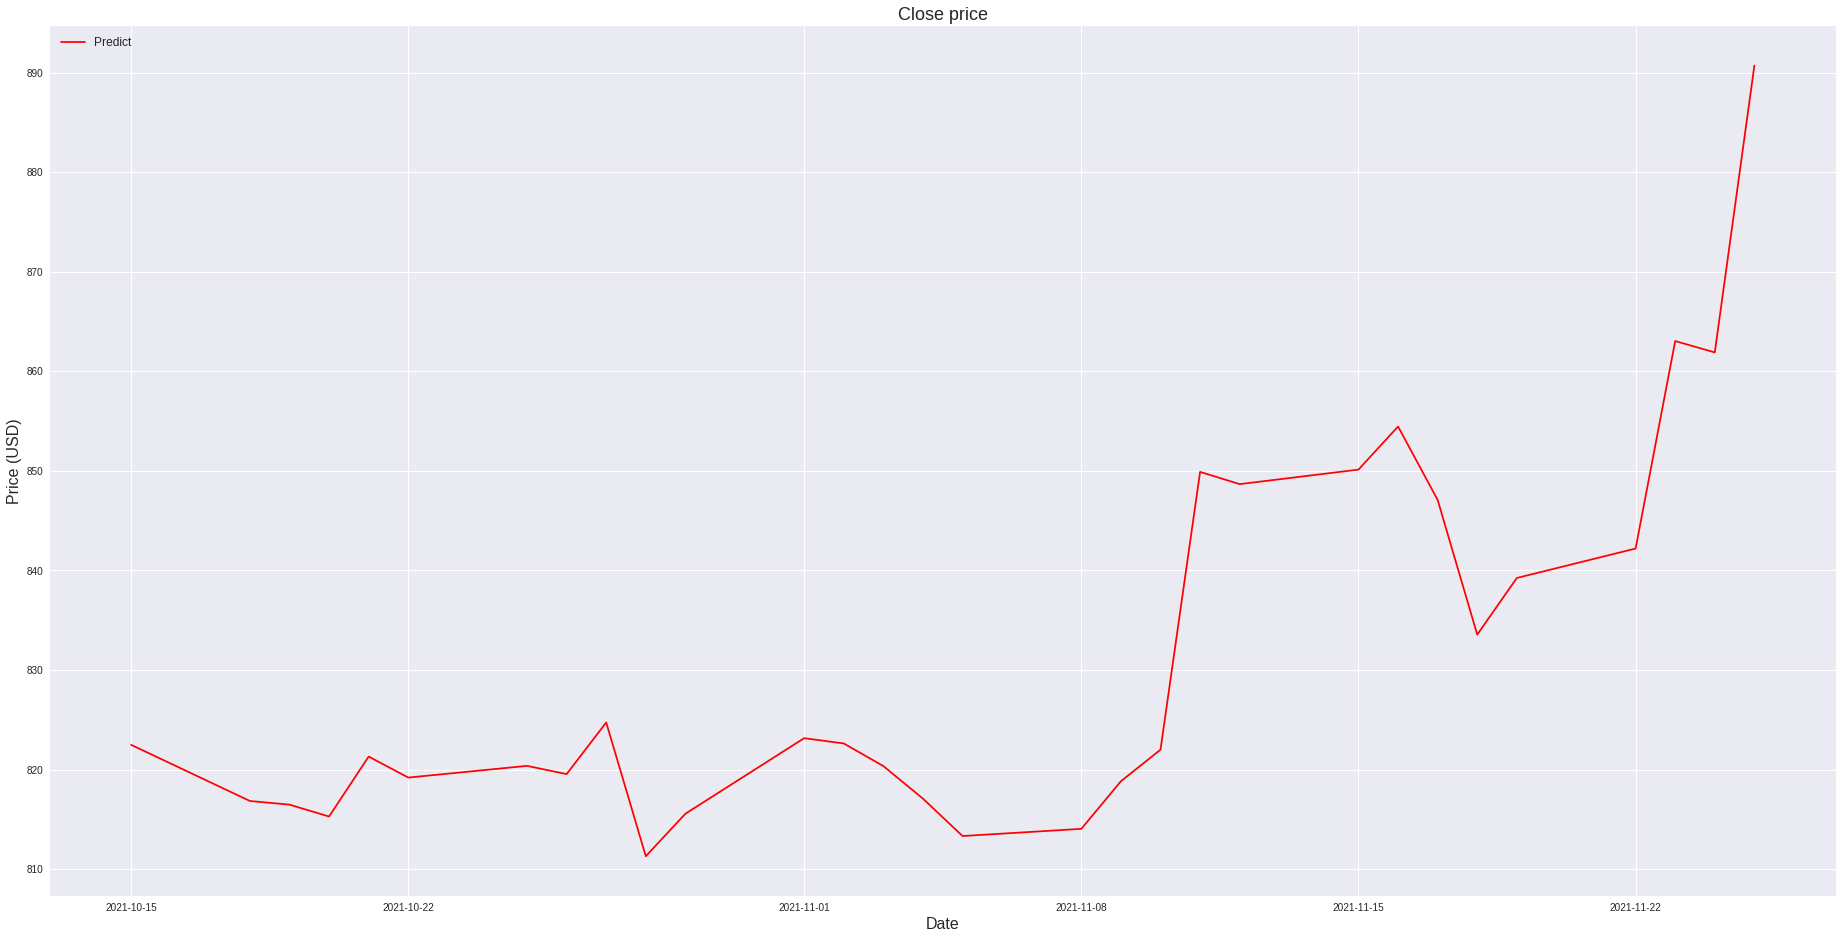

In [69]:
plot(df_future.tail(days).index,
     Ypred=y_pred_multi,
     #y_close_pred_best_svr,
     #Xtrain = y_close_train.sort_index().index,
     #Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)

###Nerualnetwork

In [45]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))
nw_model = tf.keras.Sequential(
    [
        normalizer,
        layers.Dense(8, activation="relu", name="layer2"),
        layers.Dense(4, activation="relu", name="layer3"),
        layers.Dense(1,activation="linear", name="layer5"),
    ]
)
nw_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')
nw_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 10)                21        
_________________________________________________________________
layer2 (Dense)               (None, 8)                 88        
_________________________________________________________________
layer3 (Dense)               (None, 4)                 36        
_________________________________________________________________
layer5 (Dense)               (None, 1)                 5         
Total params: 150
Trainable params: 129
Non-trainable params: 21
_________________________________________________________________


In [46]:
nw_model.fit( x_train, y_train, epochs=200, verbose=0, validation_split = 0.2)


In [47]:
x_test_temp = x_test
y_pred_nw = nw_model.predict(x_test_temp)
print(y_pred_nw)

[[908.34424]]


In [48]:
df_future = df.copy()
y_pred_nw = [0]*days

for i in range(days):
  y_pred_nw[i] = nw_model.predict(x_test_temp)
  df_future = add_next_pred_entry(df_future,y_pred_nw[i])


  #train again if needed
  #df_future_temp = df_future.dropna()
  #y_train_temp = df_future_temp[target].shift(-1).dropna()
  #x_train_temp = df_future_temp.drop(df_future_temp.tail(1).index)
  #nw_model.fit( x_train_temp, y_train_temp, epochs=50, verbose=0, validation_split = 0.2)


  x_test_temp = df_future.tail(1)


In [49]:
y_pred_nw

[array([[908.34424]], dtype=float32),
 array([[980.2114]], dtype=float32),
 array([[1053.2213]], dtype=float32),
 array([[1132.6019]], dtype=float32),
 array([[1220.4998]], dtype=float32),
 array([[1318.1254]], dtype=float32),
 array([[1425.8846]], dtype=float32),
 array([[1544.3138]], dtype=float32),
 array([[1674.5522]], dtype=float32),
 array([[1817.269]], dtype=float32),
 array([[1973.2664]], dtype=float32),
 array([[2143.4988]], dtype=float32),
 array([[2328.8162]], dtype=float32),
 array([[2530.2935]], dtype=float32),
 array([[2749.1711]], dtype=float32),
 array([[2986.6873]], dtype=float32),
 array([[3244.6504]], dtype=float32),
 array([[3524.637]], dtype=float32),
 array([[3828.3447]], dtype=float32),
 array([[4157.966]], dtype=float32),
 array([[4515.9]], dtype=float32),
 array([[4903.3555]], dtype=float32),
 array([[5322.489]], dtype=float32),
 array([[5775.674]], dtype=float32),
 array([[6265.55]], dtype=float32),
 array([[6794.939]], dtype=float32),
 array([[7366.938]], dty

###Graph

ValueError: ignored

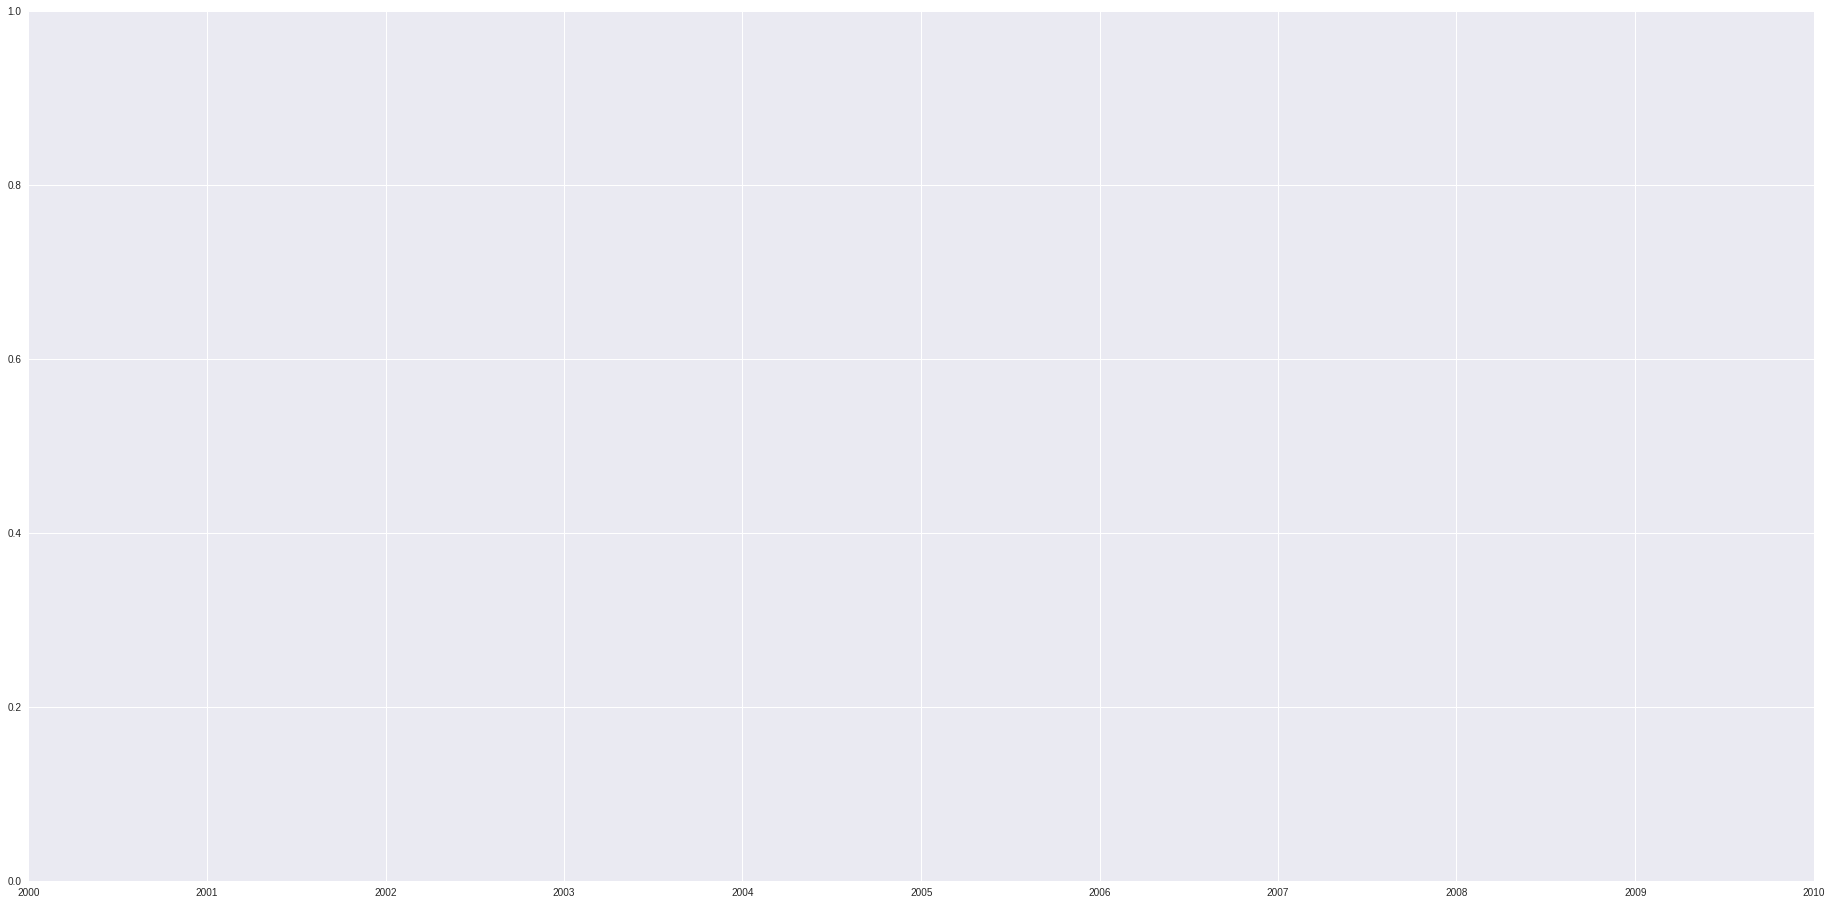

In [50]:
plot(df_future.tail(days).index,
     Ypred=y_pred_nw[0],
     #y_close_pred_best_svr,
     #Xtrain = y_close_train.sort_index().index,
     #Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)